In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
COLUMNS_STR = """    user_id
    public
    completion_percentage
    gender
    region
    last_login
    registration
    AGE
    body
    I_am_working_in_field
    spoken_languages
    hobbies
    I_most_enjoy_good_food
    pets
    body_type
    my_eyesight
    eye_color
    hair_color
    hair_type
    completed_level_of_education
    favourite_color
    relation_to_smoking
    relation_to_alcohol
    sign_in_zodiac
    on_pokec_i_am_looking_for
    love_is_for_me
    relation_to_casual_sex
    my_partner_should_be
    marital_status
    children
    relation_to_children
    I_like_movies
    I_like_watching_movie
    I_like_music
    I_mostly_like_listening_to_music
    the_idea_of_good_evening
    I_like_specialties_from_kitchen
    fun
    I_am_going_to_concerts
    my_active_sports
    my_passive_sports
    profession
    I_like_books
    life_style
    music
    cars
    politics
    relationships
    art_culture
    hobbies_interests
    science_technologies
    computers_internet
    education
    sport
    movies
    travelling
    health
    companies_brands
    more"""
COLUMNS_LIST = [col.strip() for col in COLUMNS_STR.split("\n")]


In [3]:
np.random.seed(42)

In [4]:
def select_relevant_profiles(all_profiles):
    """Select relevant profiles
    criteria:
    * is public
    * region is selected region
    * AGE specified
    * GENDER SPECIFIED
    """
    public_condition = all_profiles["public"] == 1
    age_condition = all_profiles["AGE"] > 14
    gender_condition = all_profiles["gender"].isin([0, 1])
    return all_profiles.loc[public_condition & age_condition & gender_condition]

In [5]:
def select_relevant_edges(all_edges, selected_ids):
    """Select relevant edges for those profiles that are relevant"""
    source_condition = all_edges["source"].isin(selected_ids)
    sink_condition = all_edges["sink"].isin(selected_ids)
    return all_edges.loc[source_condition & sink_condition]

In [6]:
def convert_edges_to_undirected(edges):
    """Convert edges to undirected, and keep only mutual connections"""
    undirected_edges = (
        edges.assign(
            smaller_id=lambda df: df[["source", "sink"]].min(axis=1),
            greater_id=lambda df: df[["source", "sink"]].max(axis=1),
        )
        .groupby(["smaller_id", "greater_id"])
        .agg({"source": "count"})
    )
    print(undirected_edges["source"].value_counts())
    return (
        undirected_edges.loc[undirected_edges["source"] == 2]
        .drop("source", axis=1)
        .reset_index()
    )

In [7]:
def load_and_select_profiles_and_edges():
    """load and select relevant profiles, then filter and undirect edges"""
    print("loading profiles")
    # TODO: Add some functionality to only read a subset of the data!
    profiles = pd.read_csv(
        "data/soc-pokec-profiles.txt",
        sep="\t",
        names=COLUMNS_LIST,
        index_col=False,
        usecols=["user_id", "public", "gender", "region", "AGE"],
    )
    print("loading edges")
    edges = pd.read_csv(
        "data/soc-pokec-relationships.txt", sep="\t", names=["source", "sink"]
    )
    selected_profiles = select_relevant_profiles(profiles)
    selected_ids = selected_profiles["user_id"].unique()
    selected_edges = select_relevant_edges(edges, selected_ids)

    undirected_edges = convert_edges_to_undirected(selected_edges)
    nodes_with_edges = set(undirected_edges["smaller_id"].unique()).union(
        undirected_edges["greater_id"].unique()
    )
    print(f"Selected profiles: {len(selected_profiles)}")
    print(f"Nodes with edges: {len(nodes_with_edges)}")
    selected_profiles = selected_profiles[
        selected_profiles["user_id"].isin(nodes_with_edges)
    ]
    selected_profiles["AGE"] = selected_profiles["AGE"].clip(upper=50)
    selected_profiles = remove_test_set_gender_and_age(selected_profiles)
    return selected_profiles, undirected_edges


In [245]:
def load_and_select_profiles_and_edges2():
    """load and select relevant profiles, then filter and undirect edges"""
    print("loading profiles")
    # TODO: Add some functionality to only read a subset of the data!
    profiles = pd.read_csv(
        "data/soc-pokec-profiles.txt",
        sep="\t",
        names=COLUMNS_LIST,
        index_col=False,
        usecols=["user_id", "public", "gender", "region", "AGE"],
    )
    print("loading edges")
    edges = pd.read_csv(
        "data/soc-pokec-relationships.txt", sep="\t", names=["source", "sink"]
    )
    selected_profiles = select_relevant_profiles(profiles)
    selected_ids = selected_profiles["user_id"].unique()
    selected_edges = select_relevant_edges(edges, selected_ids)

    undirected_edges = convert_edges_to_undirected(selected_edges)
    nodes_with_edges = set(undirected_edges["smaller_id"].unique()).union(
        undirected_edges["greater_id"].unique()
    )
    print(f"Selected profiles: {len(selected_profiles)}")
    print(f"Nodes with edges: {len(nodes_with_edges)}")
    selected_profiles = selected_profiles[
        selected_profiles["user_id"].isin(nodes_with_edges)
    ]
    selected_profiles["AGE"] = selected_profiles["AGE"].clip(upper=50)
    #selected_profiles = remove_test_set_gender_and_age(selected_profiles)
    return selected_profiles, undirected_edges

In [8]:
def remove_test_set_gender_and_age(nodes):
    """Remove the gender feature from a subset of the nodes for estimation"""
    # todo: the 40k  random can be adjusted if youre working with a subset
    test_profiles = np.random.choice(nodes["user_id"].unique(), 40000, replace=False)
    nodes["TRAIN_TEST"] = "TRAIN"
    test_condition = nodes["user_id"].isin(test_profiles)
    nodes.loc[test_condition, ["AGE", "gender"]] = np.nan
    nodes.loc[test_condition, ["TRAIN_TEST"]] = "TEST"

    return nodes

In [9]:
def plot_degree_distribution(G):
    """Plot a degree distribution of a graph
    TODO: log-log binning! To understand this better, check out networksciencebook.com
    """
    plot_df = (
        pd.Series(dict(G.degree)).value_counts().sort_index().to_frame().reset_index()
    )
    plot_df.columns = ["k", "count"]
    plot_df["log_k"] = np.log(plot_df["k"])
    plot_df["log_count"] = np.log(plot_df["count"])
    fig, ax = plt.subplots()

    ax.scatter(plot_df["k"], plot_df["count"])
    ax.set_xscale("log")
    ax.set_yscale("log")
    fig.suptitle("Mutual Degree Distribution")
    ax.set_xlabel("k")
    ax.set_ylabel("count_k")

# This is where our code begins

In [201]:
profiles, edges = load_and_select_profiles_and_edges()

loading profiles
loading edges
1    2642113
2    1992414
Name: source, dtype: int64
Selected profiles: 695406
Nodes with edges: 434590


In [202]:
# we duplicated the connections so that we can count the number of friends of each person
# we renamed the id_s into 'persons'
edges2 = edges[['greater_id', 'smaller_id']]
edges.rename(columns = {'smaller_id':'person1', 'greater_id':'person2'}, inplace = True)
edges2.rename(columns = {'greater_id':'person1', 'smaller_id':'person2'}, inplace = True)

# we merged the two dataframes into one and then sorted them in ascending order based on the id of person1
edges_all = pd.concat([edges, edges2], axis=0)
edges_all_sorted = edges_all.sort_values(by ='person1')

#print the merged and sorted dataframe
edges_all_sorted

,person1,person2
0,1,4
1,1,5
2,1,7
3,1,10
4,1,11
...,...,...
1992412,1632779,1632792
1992411,1632782,1632689
1992413,1632783,1632785
1992413,1632785,1632783


In [203]:
profiles.set_index("user_id", inplace = True)
profiles

,public,gender,region,AGE,TRAIN_TEST
user_id,,,,,
1,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN
4,1,0.0,"banskobystricky kraj, brezno",26.0,TRAIN
17,1,0.0,"zilinsky kraj, martin",27.0,TRAIN
5,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN
18,1,1.0,"zilinsky kraj, kysucke nove mesto",18.0,TRAIN
...,...,...,...,...,...
1632779,1,1.0,"trenciansky kraj, myjava",34.0,TRAIN
1632782,1,1.0,"bratislavsky kraj, bratislava - nove mesto",32.0,TRAIN
1632783,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN


In [204]:
#create train and test dataframes
profiles_train = profiles[profiles['TRAIN_TEST'] == 'TRAIN']
profiles_test = profiles[profiles['TRAIN_TEST'] == 'TEST']

In [205]:
#create new column for gender of person2
edges_all_sorted["gender_of_person2"] = ""
edges_all_sorted

,person1,person2,gender_of_person2
0,1,4,
1,1,5,
2,1,7,
3,1,10,
4,1,11,
...,...,...,...
1992412,1632779,1632792,
1992411,1632782,1632689,
1992413,1632783,1632785,
1992413,1632785,1632783,


In [206]:
#we set the index to the id of person2 so that we can search based on that in the profiles dataframe
edges_all_sorted.set_index("person2", inplace = True)
#we look for the gender of the index (id of person1) from the profiles database
edges_all_sorted["gender_of_person2"] = edges_all_sorted.index.map(profiles["gender"])
#we drop rows where gender data is not available
edges_with_gender = edges_all_sorted.dropna(axis=0, how='any', inplace = False)
#print dataframe
edges_with_gender

,person1,gender_of_person2
person2,,
4,1,0.0
5,1,1.0
10,1,0.0
11,1,0.0
12,1,1.0
...,...,...
1632792,1632779,0.0
1632689,1632782,0.0
1632785,1632783,1.0


In [207]:
#now from this we create two dataframes
#one where only male friends appear
#one where only female friends appear
male_friends = edges_with_gender[edges_with_gender['gender_of_person2'] == 1.0]
female_friends = edges_with_gender[edges_with_gender['gender_of_person2'] == 0.0]

In [208]:
male_friends

,person1,gender_of_person2
person2,,
5,1,1.0
12,1,1.0
1,4,1.0
183,5,1.0
1,5,1.0
...,...,...
1632782,1632689,1.0
1631281,1632689,1.0
1632785,1632783,1.0


In [209]:
female_friends

,person1,gender_of_person2
person2,,
4,1,0.0
10,1,0.0
11,1,0.0
178,5,0.0
179,5,0.0
...,...,...
1631220,1632700,0.0
1632204,1632745,0.0
1632157,1632753,0.0


In [210]:
#now we count how many times a person1 appears in the dataframe
num_of_malefriends = male_friends.groupby('person1').size().sort_values(ascending=False)
num_of_femalefriends = female_friends.groupby('person1').size().sort_values(ascending=False)

In [211]:
#for example the ID 45696 appears 241 times in the male list that means that person 45696 has 241 male friends
#for some reason these numbers change with every run, i don't know if that's a problem
#maybe it has something to do with the random selection of train and test people? 
num_of_malefriends

person1
45696      242
112925     173
47236      130
143681     125
266729     121
          ... 
408150       1
944663       1
408170       1
408171       1
1632792      1
Length: 333909, dtype: int64

In [212]:
num_of_femalefriends

person1
108211     130
277343     123
435588     116
67615      116
32576       98
          ... 
241395       1
900558       1
900553       1
900547       1
1632782      1
Length: 361652, dtype: int64

In [218]:
#these result are panda Series type, we convert them into dataframes
num_of_malefriends_df = num_of_malefriends.to_frame(name = "num of male friends")
num_of_femalefriends_df = num_of_femalefriends.to_frame(name = "num of female friends")

In [219]:
#we want to see the number of male and female friends of a person in the same dataframe
# so we add a new column to the malefriends dataframe called num of female friends
num_of_malefriends_df["num of female friends"] = ""
num_of_malefriends_df["num of female friends"] = num_of_malefriends_df.index.map(num_of_femalefriends_df["num of female friends"])
#we rename this dataframe
num_of_friends = num_of_malefriends_df
# print dataframe
num_of_friends

,num of male friends,num of female friends
person1,,
45696,242,6.0
112925,173,53.0
47236,130,44.0
143681,125,28.0
266729,121,47.0
...,...,...
408150,1,NaN
944663,1,NaN
408170,1,1.0


In [221]:
#we would like to see in the dataframe the gender of person1 too
num_of_friends["gender_of_person1"] = num_of_friends.index.map(profiles["gender"])
num_of_friends.dropna(axis=0, how='any', inplace = False)
num_of_friends

,num of male friends,num of female friends,gender_of_person1
person1,,,
45696,242,6.0,0.0
112925,173,53.0,0.0
47236,130,44.0,1.0
143681,125,28.0,NaN
266729,121,47.0,NaN
...,...,...,...
408150,1,NaN,1.0
944663,1,NaN,0.0
408170,1,1.0,1.0


In [224]:
# calculate number of all friends in a column
sum_friends = num_of_friends["num of male friends"] + num_of_friends["num of female friends"]
num_of_friends["num of friends"] = sum_friends

#calculate the proportion of male and female friends
prop_of_male_friends = num_of_friends["num of male friends"] / num_of_friends["num of friends"]
num_of_friends["proportion of male friends"] = prop_of_male_friends
prop_of_female_friends = num_of_friends["num of female friends"] / num_of_friends["num of friends"]
num_of_friends["proportion of female friends"] = prop_of_female_friends

#print database
num_of_friends

,num of male friends,num of female friends,gender_of_person1,num of friends,proportion of male friends,proportion of female friends
person1,,,,,,
45696,242,6.0,0.0,248.0,0.975806,0.024194
112925,173,53.0,0.0,226.0,0.765487,0.234513
47236,130,44.0,1.0,174.0,0.747126,0.252874
143681,125,28.0,NaN,153.0,0.816993,0.183007
266729,121,47.0,NaN,168.0,0.720238,0.279762
...,...,...,...,...,...,...
408150,1,NaN,1.0,NaN,NaN,NaN
944663,1,NaN,0.0,NaN,NaN,NaN
408170,1,1.0,1.0,2.0,0.500000,0.500000


In [227]:
#see the average proportion of male friends of males
males = num_of_friends.query('gender_of_person1 == 1.0' )
male_friends_of_males = males["proportion of male friends"].mean()
male_friends_of_males

0.5107404030141359

In [229]:
#see the average proportion of male friends of females
females = num_of_friends.query('gender_of_person1 == 0.0' )
male_friends_of_females = females["proportion of male friends"].mean()
male_friends_of_females

0.48969960311149063

This result means that males have more male friends and females have more female friends. 
This will be the basis of our prediction. If a person has more male friends than female friends, we will classify him as male, otherwise as female.

In [267]:
#now we will do our predictions, actual gender data is not here
profiles_test2 = profiles_test.drop(['public', 'region', 'AGE'], axis = 1)

profiles_test2["num of male friends"] = profiles_test2.index.map(num_of_friends["num of male friends"])
profiles_test2["num of female friends"] = profiles_test2.index.map(num_of_friends["num of female friends"])
profiles_test2["predicted gender"] = np.where(profiles_test2['num of male friends'] >= profiles_test2["num of female friends"], 1.0, 0.0)
#if ['num of male friends'] > ['num of female friends'] = '0.0'
profiles_test2

,gender,TRAIN_TEST,num of male friends,num of female friends,predicted gender
user_id,,,,,
7,NaN,TEST,11.0,9.0,1.0
24,NaN,TEST,8.0,5.0,1.0
99,NaN,TEST,10.0,10.0,1.0
136,NaN,TEST,9.0,7.0,1.0
100,NaN,TEST,15.0,26.0,0.0
...,...,...,...,...,...
1632297,NaN,TEST,1.0,NaN,0.0
1632387,NaN,TEST,NaN,NaN,0.0
1632515,NaN,TEST,1.0,NaN,0.0


In [277]:
#we load the data again, but this time gender is not removed from the test set
profiles_v2, edges_v2 = load_and_select_profiles_and_edges2()

loading profiles
loading edges
1    2642113
2    1992414
Name: source, dtype: int64
Selected profiles: 695406
Nodes with edges: 434590


In [278]:
profiles_v2.set_index("user_id", inplace = True)
profiles_v2

,public,gender,region,AGE
user_id,,,,
1,1,1.0,"zilinsky kraj, zilina",26.0
4,1,0.0,"banskobystricky kraj, brezno",26.0
17,1,0.0,"zilinsky kraj, martin",27.0
5,1,1.0,"zilinsky kraj, zilina",26.0
18,1,1.0,"zilinsky kraj, kysucke nove mesto",18.0
...,...,...,...,...
1632779,1,1.0,"trenciansky kraj, myjava",34.0
1632782,1,1.0,"bratislavsky kraj, bratislava - nove mesto",32.0
1632783,1,1.0,"trenciansky kraj, povazska bystrica",37.0


In [279]:
#find the actual genders
profiles_test2["actual gender"] = profiles_test2.index.map(profiles_v2["gender"])

#if predicted and actual genders are the same we write 1, otherwise 0
profiles_test2["prediction ok?"] = np.where(profiles_test2['predicted gender'] == profiles_test2["actual gender"], 1.0, 0.0)
profiles_test2

,gender,TRAIN_TEST,num of male friends,num of female friends,predicted gender,actual gender,prediction ok?
user_id,,,,,,,
7,NaN,TEST,11.0,9.0,1.0,0.0,0.0
24,NaN,TEST,8.0,5.0,1.0,1.0,1.0
99,NaN,TEST,10.0,10.0,1.0,0.0,0.0
136,NaN,TEST,9.0,7.0,1.0,1.0,1.0
100,NaN,TEST,15.0,26.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
1632297,NaN,TEST,1.0,NaN,0.0,0.0,1.0
1632387,NaN,TEST,NaN,NaN,0.0,1.0,0.0
1632515,NaN,TEST,1.0,NaN,0.0,0.0,1.0


In [281]:
#count the number of correct predictions
num_of_correct_predictions = profiles_test2['prediction ok?'].sum()
#calculate the proportion of correct predictions
accuracy = num_of_correct_predictions/40000

print ("The number of correct predictions is:") 
print(num_of_correct_predictions)

print("The accuracy of the model is:")
print(accuracy)

The number of correct predictions is:
20056.0
The accuracy of the model is:
0.5014


Our model can predict correctly in 50,14% of the cases. 

# Graphs

In [303]:
import pandas as pd
import networkx as nx
import numpy as np

In [304]:
def create_graph_from_nodes_and_edges(nodes, edges):
    """Create a networkx graph object with all relevant features"""
    node_attributes = nodes.set_index("user_id").to_dict(orient="index")
    node_attributes_list = [
        (index, attr_dict) for index, attr_dict in node_attributes.items()
    ]
    G = nx.Graph()
    G.add_nodes_from(node_attributes_list)
    G.add_edges_from(edges.values.tolist())
    return G

In [322]:
G = create_graph_from_nodes_and_edges(profiles, edges)

In [305]:
def get_nbrs_for_node(node_id, G):
    """Return ids of nbrs of node"""
    return list(dict(G[node_id]).keys())

In [306]:
def get_features_of_node_list(node_list, node_df):
    """Return the features of a subset of nodes"""
    return node_df.loc[node_list, ["AGE", "gender"]].values.tolist()

In [307]:
def add_node_features_to_edges(nodes, edges):
    """Add features of nodes to edges in order to create heatmaps"""
    # TODO: column names could be nicer!
    edges_w_features = edges.merge(
        nodes[["user_id", "AGE", "gender"]].set_index("user_id"),
        how="left",
        left_on="smaller_id",
        right_index=True,
    )
    edges_w_features = edges_w_features.merge(
        nodes[["user_id", "AGE", "gender"]].set_index("user_id"),
        how="left",
        left_on="greater_id",
        right_index=True,
    )
    return edges_w_features

In [326]:
edges_with_features = add_node_features_to_edges(profiles, edges)

In [309]:
def plot_degree_distribution(G):
    """Plot a degree distribution of a graph
    TODO: log-log binning! To understand this better, check out networksciencebook.com
    """
    plot_df = (
        pd.Series(dict(G.degree)).value_counts().sort_index().to_frame().reset_index()
    )
    plot_df.columns = ["k", "count"]
    plot_df["log_k"] = np.log(plot_df["k"])
    plot_df["log_count"] = np.log(plot_df["count"])
    fig, ax = plt.subplots()

    ax.scatter(plot_df["k"], plot_df["count"])
    ax.set_xscale("log")
    ax.set_yscale("log")
    fig.suptitle("Mutual Degree Distribution")
    ax.set_xlabel("k")
    ax.set_ylabel("count_k")

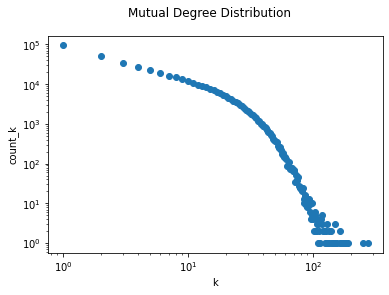

In [324]:
plot_degree_distribution(G)

The degree distribution is not scale-free.

In [316]:
def plot_age_distribution_by_gender(nodes):
    """Plot a histogram where the color represents gender"""
    plot_df = nodes[["AGE", "gender"]].copy(deep=True).astype(float)
    plot_df["gender"] = plot_df["gender"].replace({0.0: "woman", 1.0: "man"})
    sns.histplot(data=plot_df, x="AGE", hue="gender", bins=np.arange(0, 45, 5) + 15)

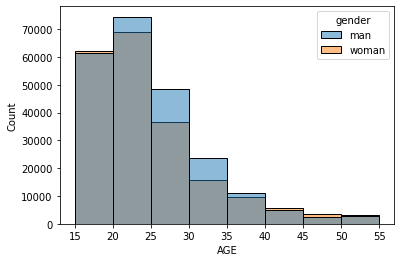

In [319]:
plot_age_distribution_by_gender(profiles)

The chart shows the number of people between certain ages. We can see that younger generations are overrepresented in the data. Most people are between the ages of 20 and 25. This is not surprising, as younger people are more likely to use social media. Among young people the number of men is higher, while among older people women are slightly overrepresented.

In [311]:
def plot_node_degree_by_gender(nodes, G):
    """Plot the average of node degree across age and gender"""
    # TODO: this could be generalized for different node level statistics as well!
    nodes_w_degree = nodes.set_index("user_id").merge(
        pd.Series(dict(G.degree)).to_frame(),
        how="left",
        left_index=True,
        right_index=True,
    )
    nodes_w_degree = nodes_w_degree.rename({0: "degree"}, axis=1)
    plot_df = (
        nodes_w_degree.groupby(["AGE", "gender"]).agg({"degree": "mean"}).reset_index()
    )
    sns.lineplot(data=plot_df, x="AGE", y="degree", hue="gender")

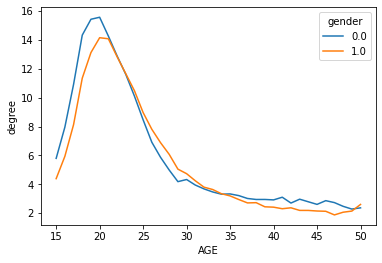

In [323]:
plot_node_degree_by_gender(profiles, G)

On this chart we can see the average number of people a user with a certain age is connected with. Connectivity is highest among 18-20 year-olds, and it decreases with age. On average women have more connections when they are younger, however, at around age 25 males become the ones with higher connectivity. At age 35 there is another switch, from that point on women have a higher degree again. 

In [312]:
def plot_age_relations_heatmap(edges_w_features):
    """Plot a heatmap that represents the distribution of edges"""
    # TODO: check what happpens without logging
    # TODO: instead of logging check what happens if you normalize with the row sum
    #  make sure you figure out an interpretation of that as well!
    # TODO: separate these charts by gender as well
    # TODO: column names could be nicer
    plot_df = edges_w_features.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    plot_df_w_w = plot_df.loc[(0, 0)].reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    sns.heatmap(plot_df_heatmap_logged)

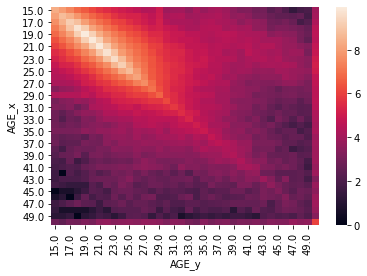

In [327]:
plot_age_relations_heatmap(edges_with_features)

The heatmap shows the amount of connections between certain age groups. We can see that the upper left corner is the brithest, which means there are lots of connections among young people. There is a general brighter diagonal line running from the upper left corner to the bottom right corner. This shows that people tend to have connections with those of the same age. 